# Unsupervised Predictions Alignment - WILDS CameLyon dataset

In [1]:
import sys

root = "."
sys.path.append(root)

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from metrics_utils import (
    get_summary_df_from_preds_df,
    get_all_camelyon_results,
    get_op_threshold,
)

from experiment_utils import evaluate_alignement_with_repeated_sampling
from plotting_utils import plot_results_ablation_studies

pd.set_option("display.precision", 3)

from IPython.display import display

(Path(root) / "plots").mkdir(exist_ok=True)

plt.rcParams.update({"font.size": 12})

In [2]:
# Load the model predictions
model_subdir = "camelyon"
model_dir = Path(root) / model_subdir
all_dfs = get_all_camelyon_results(model_dir)
aggregated = pd.concat(all_dfs.values(), ignore_index=True)
label_column = "label"

# Look at raw results without any adaption for all available sets

In [3]:
# Compute threshold on ID
reference_df = all_dfs["id_val"]
reference_thres = get_op_threshold(reference_df[label_column], reference_df.pred1)[0]
# Get the first metrics
get_summary_df_from_preds_df(
    all_dfs.values(), reference_thres, bootstrap=False, label_column=label_column
)

,ROCAUC,vendOP,vendSens/Spec,GlobalOP,globalSens/Spec,Global Spec/Sens Diff,Global Youden
['id_val'],0.998,0.417,0.983/0.983,0.417,0.983/0.983,-0.000,0.966
['val'],0.979,0.130,0.932/0.932,0.417,0.897/0.971,0.074,0.868
['test'],0.975,0.233,0.929/0.929,0.417,0.902/0.961,0.059,0.863


In [5]:
df_total = pd.pivot_table(
    data=aggregated,
    values="id",
    index="vendor",
    columns=label_column,
    aggfunc=lambda x: np.unique(x).size,
)
df_total

label,0,1
vendor,,
id_val,16952,16608
test,42527,42527
val,17452,17452


## Experiments

### Scenario 1: Alignment on OOD dataset with model calibrated on ID only.

In [6]:
n_repeat = 500
datasets_to_evaluate = ["val", "test"]

VAL


/var/folders/tg/4dclb0c96418c_nmksf9mrch0000gn/T/ipykernel_46503/4161084985.py:14: FutureWarning: ['N_patients_alignment', 'N_patients_reference'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  display(results.groupby("Predictions").aggregate(["mean", "std"]))


N_images_in_alignment_set      N_images_in_evaluation_set       \
                                 mean  std                       mean  std   
Predictions                                                                  
Aligned                        5000.0  0.0                    15000.0  0.0   
Original                       5000.0  0.0                    15000.0  0.0   

            N_images_in_reference_set      roc_auc              sens         \
                                 mean  std    mean        std   mean    std   
Predictions                                                                   
Aligned                        5000.0  0.0   0.979  8.027e-04  0.927  0.008   
Original                       5000.0  0.0   0.979  8.027e-04  0.897  0.003   

              spec        youden           mcc         \
              mean    std   mean    std   mean    std   
Predictions                                             
Aligned      0.937  0.012  0.864  0.005  0.865  0.005   
Original     0.971  0.001  0.868  0.003  0.870  0.003   

            Difference Sensitivity - Specifity         
                                          mean    std  
Predictions                                            
Aligned                                 -0.010  0.020  
Original                                -0.074  0.003

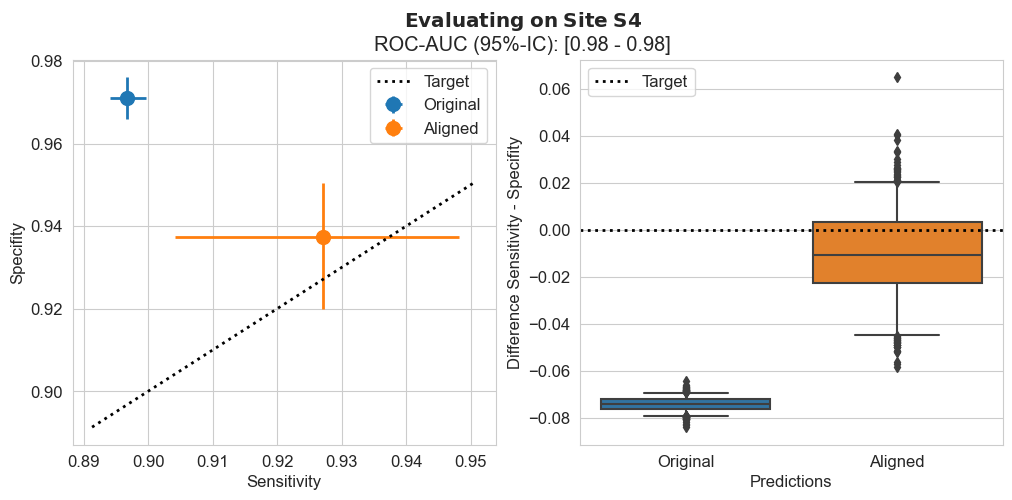

TEST


/var/folders/tg/4dclb0c96418c_nmksf9mrch0000gn/T/ipykernel_46503/4161084985.py:14: FutureWarning: ['N_patients_alignment', 'N_patients_reference'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  display(results.groupby("Predictions").aggregate(["mean", "std"]))


N_images_in_alignment_set      N_images_in_evaluation_set       \
                                 mean  std                       mean  std   
Predictions                                                                  
Aligned                        5000.0  0.0                    15000.0  0.0   
Original                       5000.0  0.0                    15000.0  0.0   

            N_images_in_reference_set      roc_auc          sens         \
                                 mean  std    mean    std   mean    std   
Predictions                                                               
Aligned                        5000.0  0.0   0.976  0.001  0.924  0.008   
Original                       5000.0  0.0   0.976  0.001  0.902  0.003   

              spec        youden           mcc         \
              mean    std   mean    std   mean    std   
Predictions                                             
Aligned      0.934  0.012  0.859  0.006  0.859  0.006   
Original     0.961  0.002  0.863  0.004  0.865  0.004   

            Difference Sensitivity - Specifity         
                                          mean    std  
Predictions                                            
Aligned                                 -0.010  0.019  
Original                                -0.058  0.004

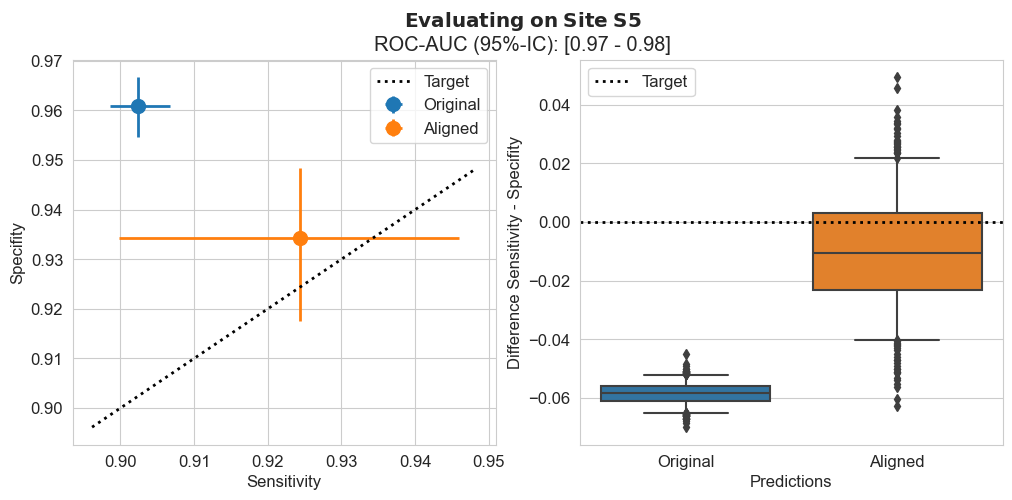

In [7]:
for dataset in datasets_to_evaluate:
    df = all_dfs[dataset]
    results = evaluate_alignement_with_repeated_sampling(
        df,
        reference_df,
        reference_thres,
        n_repeat=n_repeat,
        alignment_size=5000,
        test_size=15000,
        reference_size=5000,
        label_column="label",
    )
    print(dataset.upper())
    display(results.groupby("Predictions").aggregate(["mean", "std"]))
    name = "S4" if dataset == "val" else "S5"
    plot_results_ablation_studies(results, "Predictions", name, site_prefix="Site")

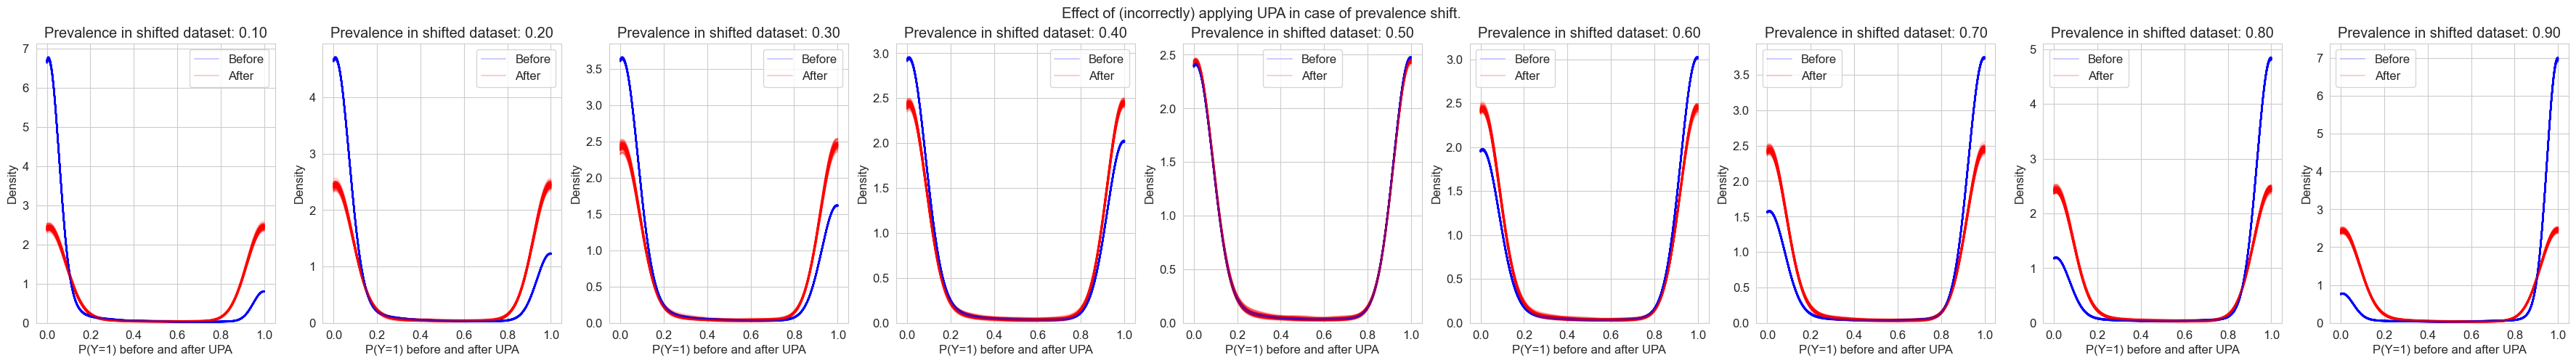

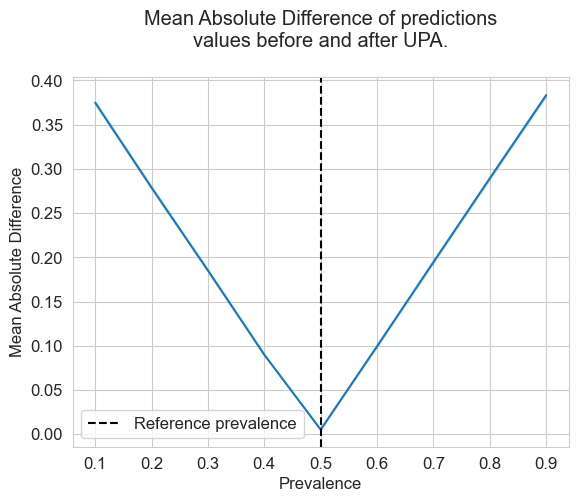

In [11]:
from sklearn.model_selection import train_test_split
import seaborn as sns
from experiment_utils import fit_and_evaluate_shift_detection

n_repeat = 100
prevalences = np.linspace(0.1, 0.9, 9)

df = all_dfs["id_val"]

all_patients = df.id.values

all_results_df = []
f, ax = plt.subplots(1, len(prevalences), figsize=(len(prevalences) * 5, 5))
for p in range(len(prevalences)):
    all_results_df_p = []
    for i in range(n_repeat):

        # Split between "reference" and "target" distribution.
        # Reference distribution is 50% prevalence
        # Alignment and ref will be sampled such that they have the given prevalence
        ref_patients, target_patients = train_test_split(
            all_patients, train_size=5000, stratify=df.label.values
        )

        reference_df = df.loc[df.id.isin(ref_patients)]
        reference_thres = get_op_threshold(
            reference_df[label_column], reference_df.pred1
        )[0]

        target_df = df.loc[df.id.isin(target_patients)]
        target_positive_patients = df.loc[df.label == 1].id.values
        target_negative_patients = df.loc[df.label == 0].id.values

        total_test_size = 10000
        total_alignment_size = 5000
        prevalence = prevalences[p]
        n_positive_test = int(prevalence * total_test_size)
        n_positive_align = int(prevalence * total_alignment_size)
        #    Split patients in testing and alignment splits
        (
            patients_for_alignment_positives,
            patients_for_testing_positives,
        ) = train_test_split(
            target_positive_patients,
            test_size=n_positive_test,
            train_size=n_positive_align,
        )

        (
            patients_for_alignment_negatives,
            patients_for_testing_negatives,
        ) = train_test_split(
            target_negative_patients,
            test_size=total_test_size - n_positive_test,
            train_size=total_alignment_size - n_positive_align,
        )
        patients_for_alignment = np.concatenate(
            [patients_for_alignment_negatives, patients_for_alignment_positives]
        )
        patients_for_testing = np.concatenate(
            [patients_for_testing_negatives, patients_for_testing_positives]
        )

        df_for_alignment = df.loc[df.id.isin(patients_for_alignment)]
        df_for_testing = df.loc[df.id.isin(patients_for_testing)]

        assert df_for_alignment.id.unique().size == total_alignment_size, str(
            df_for_alignment.id.unique().size
        )
        all_results_df_p.append(
            fit_and_evaluate_shift_detection(
                reference_df, df_for_alignment, df_for_testing, ax=ax[p]
            )
        )
    results_p = pd.concat(all_results_df_p, ignore_index=True)
    results_p["Prevalence"] = prevalences[p]
    all_results_df.append(results_p)
    ax[p].legend(labels=["Before", "After"])
    ax[p].set_xlabel("P(Y=1) before and after UPA")
    ax[p].set_title(f"Prevalence in shifted dataset: {prevalences[p]:.2f}")

all_results = pd.concat(all_results_df, ignore_index=True)
plt.suptitle("Effect of (incorrectly) applying UPA in case of prevalence shift.")
plt.savefig("plots/prevalence_shift_kde.pdf", bbox_inches="tight")
plt.show()
sns.lineplot(data=all_results, x="Prevalence", y="MAD")
plt.title("Mean Absolute Difference of predictions\nvalues before and after UPA.\n")
plt.ylabel("Mean Absolute Difference")
plt.axvline(x=0.5, label="Reference prevalence", color="black", ls="--")
plt.legend(loc="lower left")
plt.savefig("plots/mad_prevalence_shift.pdf", bbox_inches="tight")

plt.show()